# Pseudocode

 ## Cleaning:
    - NaN/?/Blank
        - waterfront
        - view
        - yr_rennovated
        - sqft_basement
    - whitespace *no issue
    - format to int/float
        - view
        - waterfront
        - condition
        - grade
        - sqft_basement
    - deal with dupes
        - several properties are listed more than once, suggesting they were bought/sold during this timeframe. 
    - categorical encoding
        - bedrooms
        - bathrooms
        - floors
        - zipcode
        - waterfront
        - view
        - condition
        - grade
    - duplicate properties
        - Located, need to decide how to treat. 
    - drop unused columns
        - lat/long once done with all other steps. Technically this combination is categorical.
        - date
        - sqft_basement? - 454 records do not have a value here--we would need to drop these records at a minimum.
    - save cleaned data
    
    
 ## Simple Model
     - add features
     - transform features (log transform?)
     
     
     
 ## Business Problem/Stakeholders
 
 We (Antom Research) are based in King County and working on a project for a real estate investment trust. They would like us to use our area expertise to advise them on what sort of properties are likely to maximize the value of their investment. They have been tight-lipped about their plans for the properties they purchase, so we do not know if they intend to buy and hold, rennovate, demolish and rebuild, etc.
 
   
     
     

## Data Understanding

Address limitations of data. Target properties below the expected price_sqft in appealing zip codes.
Very few properties that demonstrate 

# Imports

In [2]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm


from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Simple Data - omitted columns recommended in project description


In [3]:
simple_housing = pd.read_csv('../data/kc_house_data.csv')

In [4]:
complexities = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'zipcode', 'sqft_living15', 'sqft_lot15']

In [5]:
simple_housing.drop(columns=complexities, inplace=True)

In [6]:
simple_housing.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987


In [7]:
# Add price per square foot feature
simple_housing['price_sqft'] = simple_housing['price'] / simple_housing['sqft_living']

In [8]:
# drop waterfront & confirm no NaNs
simple_housing = simple_housing.drop(columns='waterfront')
simple_housing.isna().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
condition      0
grade          0
yr_built       0
price_sqft     0
dtype: int64

In [9]:
simple_housing.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,price_sqft
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,7 Average,1955,188.050847
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,7 Average,1951,209.338521
2,5631500400,180000.0,2,1.00,770,10000,1.0,Average,6 Low Average,1933,233.766234
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,7 Average,1965,308.163265
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,8 Good,1987,303.571429


In [10]:
# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['condition', 'grade']
cat_df = simple_housing[categoricals]
cat_df.head()

,condition,grade
0,Average,7 Average
1,Average,7 Average
2,Average,6 Low Average
3,Very Good,7 Average
4,Average,8 Good


In [11]:
# OneHot encoding for categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
categorical_cats = ohe.fit_transform(cat_df)
categorical_cats.todense()
categorical_df = pd.DataFrame(categorical_cats.todense(), columns=ohe.get_feature_names(categoricals))
categorical_df.head()

,condition_Fair,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# Confirm identical # of records before concatenating.
print(categorical_df.shape)
print(simple_housing.shape)

(21597, 14)
(21597, 11)


In [13]:
# Drop origical categorical columns, concatenate encoded columns.
data = simple_housing.drop(columns=categoricals)
kc_encoded = pd.concat([data.reset_index(drop=True), categorical_df.reset_index(drop=True)], axis=1)

In [14]:
# Confirm no new records added & categoricals are gone.
print(kc_encoded.shape)
kc_encoded.info()

(21597, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21597 non-null  int64  
 1   price                21597 non-null  float64
 2   bedrooms             21597 non-null  int64  
 3   bathrooms            21597 non-null  float64
 4   sqft_living          21597 non-null  int64  
 5   sqft_lot             21597 non-null  int64  
 6   floors               21597 non-null  float64
 7   yr_built             21597 non-null  int64  
 8   price_sqft           21597 non-null  float64
 9   condition_Fair       21597 non-null  float64
 10  condition_Good       21597 non-null  float64
 11  condition_Poor       21597 non-null  float64
 12  condition_Very Good  21597 non-null  float64
 13  grade_11 Excellent   21597 non-null  float64
 14  grade_12 Luxury      21597 non-null  float64
 15  grade_13 Mansion     215

In [15]:
# Save off encoded data
kc_encoded.to_csv('../data/kc_encoded.csv')

## Dummy Regressor

In [16]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.linear_model import LinearRegression

X = kc_encoded.drop(columns=['price_sqft', 'id'])
y = kc_encoded['price_sqft']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41, test_size=0.33)
lm = LinearRegression().fit(X_train, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)
y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)


In [18]:
print('Linear model, coefficients: ', lm.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_mean)))
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))

print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median)))
print("Median absolute error (linear model): {:.2f}".format(median_absolute_error(y_test, y_predict)))

print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict)))


Linear model, coefficients:  [ 3.52940381e-04 -6.81607734e+00 -2.40699002e+00 -1.10785750e-01
  4.86465066e-05  9.65157285e+00 -5.00111053e-01 -2.12973209e+01
 -2.73569718e+00  1.71814935e+01 -4.29639374e+00 -1.37373515e+01
 -9.99269027e+01 -3.92655980e+02  1.04692406e+02  3.15455782e+01
 -5.16796518e+01 -4.76860280e+01 -3.32404548e+01 -1.46802236e+01
  1.27427061e+00]
Mean squared error (dummy): 11965.15
Mean squared error (linear model): 2494.72
Median absolute error (dummy): 65.70
Median absolute error (linear model): 22.20
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.03
r2_score (linear model): 0.79


## Exploring kc_encoded

In [19]:
# define X, y
X = kc_encoded.drop(columns=['price_sqft', 'id'])
y = kc_encoded['price_sqft']

In [20]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=41)

In [21]:
#train_df = pd.concat([X_train, y_train], axis=1)

In [22]:
#sns.pairplot(train_df)
#plt.show()

In [23]:
# add constant term/y-intercept to train data
X_preds = sm.add_constant(X_train)

In [24]:
# First model
model = sm.OLS(endog=y_train, exog=X_preds).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqft   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     2649.
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:25:13   Log-Likelihood:                -77158.
No. Observations:               14469   AIC:                         1.544e+05
Df Residuals:                   14447   BIC:                         1.545e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1327.1398     39.942     33.226      0.000    1248.848    1405.432
price                   0.0004   1.91e-06    184.528      0.000       0.000       0.000
bedrooms               -6.8161      0.577    -11.821      0.000      -7.946      -5.686
bathrooms              -2.4070      0.984     -2.446      0.014      -4.336      -0.478
sqft_living            -0.1108      0.001   -110.624      0.000      -0.113      -0.109
sqft_lot             4.865e-05   1.07e-05      4.537      0.000    2.76e-05    6.97e-05
floors                  9.6516      0.988      9.768      0.000       7.715      11.588
yr_built               -0.5001      0.020    -24.842      0.000      -0.540      -0.461
condition_Fair        -21.2973      4.723     -4.509      0.000     -30.555     -12.039
condition_Good         -2.7357      1.033     -2.648      0.008      -4.761      -0.711
condition_Poor         17.1815     11.590      1.482      0.138      -5.537      39.900
condition_Very Good    -4.2964      1.692     -2.540      0.011      -7.612      -0.981
grade_11 Excellent    -13.7374      3.643     -3.771      0.000     -20.878      -6.597
grade_12 Luxury       -99.9269      7.274    -13.738      0.000    -114.185     -85.669
grade_13 Mansion     -392.6560     21.293    -18.440      0.000    -434.394    -350.918
grade_3 Poor          104.6924     50.251      2.083      0.037       6.194     203.191
grade_4 Low            31.5456     12.565      2.511      0.012       6.917      56.174
grade_5 Fair          -51.6797      5.052    -10.229      0.000     -61.583     -41.777
grade_6 Low Average   -47.6860      3.163    -15.076      0.000     -53.886     -41.486
grade_7 Average       -33.2405      2.614    -12.716      0.000     -38.364     -28.116
grade_8 Good          -14.6802      2.369     -6.196      0.000     -19.325     -10.036
grade_9 Better          1.2743      2.305      0.553      0.580      -3.243       5.792
==============================================================================
Omnibus:                     4382.354   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           339451.090
Skew:                           0.535   Prob(JB):                         0.00
Kurtosis:                      26.705   Cond. No.                     7.91e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.91e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Observations on 1st MultReg Model:
#     High pvalues:'grade_4 Low'
#     Solid R2 of 0.797
#     Coefficients hard to understand due to scaling.

In [26]:
#train_df.corr()

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# defining an empty dataframe to capture the VIF scores
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

# label the scores with their related columns
vif["features"] = X_train.columns

vif

,VIF,features
0,7.789729,price
1,23.221021,bedrooms
2,25.709180,bathrooms
3,29.800666,sqft_living
4,1.204192,sqft_lot
5,13.768539,floors
6,80.576315,yr_built
7,1.037056,condition_Fair
8,1.559462,condition_Good
9,1.015030,condition_Poor


In [28]:

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [29]:
# Check R2 for Train/Test data.
from sklearn.metrics import r2_score

print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
print(f"Test R2: {r2_score(y_test, test_preds):.4f}")

Train R2: 0.7938
Test R2: 0.7915


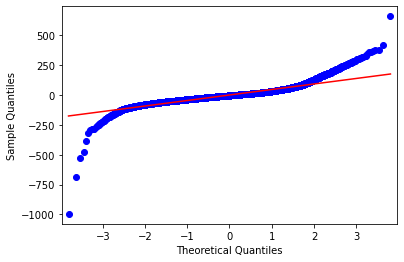

In [30]:
# Checking for normality

# Calculate our residuals
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

# QQ Plot
sm.qqplot(train_residuals, line = 'r');

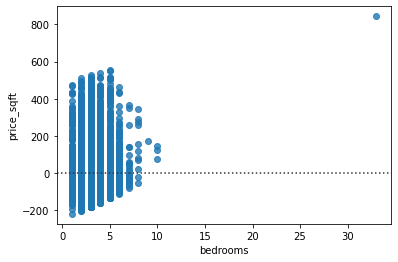

In [31]:
sns.residplot(x=X_train['bedrooms'], y=y_train)
plt.show()

In [32]:
# Might see some improvement if we get rid of our outliers in the bedrooms category. Relatively few that have > 8 rooms
# May improve our QQ plot as well.
kc_encoded.loc[kc_encoded['bedrooms'] > 8]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,price_sqft,condition_Fair,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
4092,1997200215,599999.0,9,4.50,3830,6988,2.5,1938,156.657702,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4231,2902200015,700000.0,9,3.00,3680,4400,2.0,1908,190.217391,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6073,9822700190,1280000.0,9,4.50,3650,5000,2.0,1915,350.684932,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8537,424049043,450000.0,9,7.50,4050,6504,2.0,1996,111.111111,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8748,1773100755,520000.0,11,3.00,3000,4960,2.0,1918,173.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13301,627300145,1150000.0,10,5.25,4590,10920,1.0,2008,250.544662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15147,5566100170,650000.0,10,2.00,3610,11914,2.0,1958,180.055402,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,1947,395.061728,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16830,8823900290,1400000.0,9,4.00,4620,5508,2.5,1915,303.030303,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18428,8823901445,934000.0,9,3.00,2820,4480,2.0,1918,331.205674,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


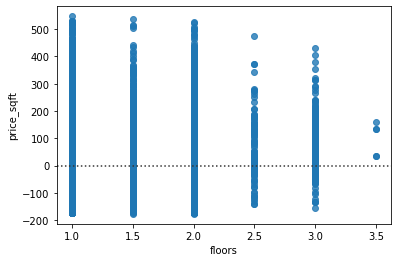

In [33]:
sns.residplot(x=X_train['floors'], y=y_train)
plt.show()

In [34]:
#Might be worth removing properties with > 3 floors as well to improve homoskedasticity. only 7 outliers with >3.
kc_encoded.loc[kc_encoded['floors'] > 3]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,price_sqft,condition_Fair,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
10066,1972202010,435000.0,3,3.00,1440,1350,3.5,2005,302.083333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11582,3180100023,544000.0,3,2.50,1760,1755,3.5,1998,309.090909,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14871,8673400177,525000.0,3,3.00,1730,1074,3.5,2006,303.468208,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15410,1702900664,479000.0,2,2.50,1730,1037,3.5,2008,276.878613,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18462,1346300150,3300000.0,8,4.00,7710,11750,3.5,1904,428.015564,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20292,1972200426,525000.0,2,2.75,1310,1268,3.5,2007,400.763359,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20756,1972200428,563500.0,3,2.50,1400,1312,3.5,2007,402.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Adding Zipcode Feature

In [35]:
# Re-read .csv Data
simple_housing_zip = pd.read_csv('../data/kc_house_data.csv')

# Redefine Complexities to exclude zipcode
complexities2 = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

# Generate new DF inclusive of zipcode.
simple_housing_zip.drop(columns=complexities2, inplace=True)

# Add price per square foot feature
simple_housing_zip['price_sqft'] = simple_housing_zip['price'] / simple_housing_zip['sqft_living']

# drop waterfront & confirm no NaNs
simple_housing_zip.drop(columns='waterfront', inplace=True)
simple_housing_zip.isna().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
condition      0
grade          0
yr_built       0
zipcode        0
price_sqft     0
dtype: int64

In [36]:
# Include zipcode in our original list of categoricals & create new df with only the categorical columns.
categoricals2 = ['condition', 'grade', 'zipcode']
cat_df2 = simple_housing_zip[categoricals2]
cat_df2.head()

,condition,grade,zipcode
0,Average,7 Average,98178
1,Average,7 Average,98125
2,Average,6 Low Average,98028
3,Very Good,7 Average,98136
4,Average,8 Good,98074


In [37]:
# OneHot encoding for new categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
zip_cats = ohe.fit_transform(cat_df2)
zip_cats.todense()
zip_df = pd.DataFrame(zip_cats.todense(), columns=ohe.get_feature_names(categoricals2))
zip_df.head()

,condition_Fair,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Drop origical categorical columns, concatenate encoded columns.
zip_data = simple_housing_zip.drop(columns=categoricals2)
kc_encoded_zip = pd.concat([zip_data.reset_index(drop=True), zip_df.reset_index(drop=True)], axis=1)

In [39]:
kc_encoded_zip.shape

(21597, 92)

In [40]:
# define X, y
X_zip = kc_encoded_zip.drop(columns=['price_sqft', 'id'])
y_zip = kc_encoded_zip['price_sqft']

# Train / Test split
X_zip_train, X_zip_test, y_zip_train, y_zip_test = train_test_split(
    X_zip, y_zip, test_size=0.33, random_state=41)

# add constant term/y-intercept to train data
X_zip_preds = sm.add_constant(X_zip_train)

In [41]:
#2nd model with zip codes
model = sm.OLS(endog=y_zip_train, exog=X_zip_preds).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqft   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     882.4
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:25:15   Log-Likelihood:                -75013.
No. Observations:               14469   AIC:                         1.502e+05
Df Residuals:                   14378   BIC:                         1.509e+05
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 574.5120     40.776     14.089      0.000     494.586     654.438
price                   0.0003   2.16e-06    129.624      0.000       0.000       0.000
bedrooms               -5.3590      0.507    -10.561      0.000      -6.354      -4.364
bathrooms              -4.0325      0.860     -4.690      0.000      -5.718      -2.347
sqft_living            -0.0944      0.001   -101.780      0.000      -0.096      -0.093
sqft_lot                0.0001      1e-05     11.164      0.000    9.22e-05       0.000
floors                 -2.0120      0.926     -2.174      0.030      -3.826      -0.198
yr_built               -0.1354      0.020     -6.609      0.000      -0.176      -0.095
condition_Fair        -18.6772      4.097     -4.559      0.000     -26.707     -10.647
condition_Good          1.1290      0.926      1.219      0.223      -0.686       2.944
condition_Poor          3.4058     10.066      0.338      0.735     -16.326      23.137
condition_Very Good    -0.8739      1.491     -0.586      0.558      -3.796       2.048
grade_11 Excellent      1.2777      3.175      0.402      0.687      -4.945       7.500
grade_12 Luxury       -49.0125      6.374     -7.689      0.000     -61.507     -36.518
grade_13 Mansion     -244.9710     18.687    -13.110      0.000    -281.599    -208.343
grade_3 Poor          168.8801     43.593      3.874      0.000      83.432     254.328
grade_4 Low            59.1956     10.925      5.418      0.000      37.781      80.610
grade_5 Fair          -25.2743      4.461     -5.666      0.000     -34.018     -16.531
grade_6 Low Average   -32.4211      2.819    -11.500      0.000     -37.947     -26.895
grade_7 Average       -31.3485      2.322    -13.501      0.000     -35.900     -26.797
grade_8 Good          -19.4205      2.089     -9.297      0.000     -23.515     -15.326
grade_9 Better         -2.8199      2.017     -1.398      0.162      -6.773       1.133
zipcode_98002         -13.0936      4.631     -2.827      0.005     -22.171      -4.016
zipcode_98003           1.8722      4.237      0.442      0.659      -6.433      10.177
zipcode_98004         106.3909      4.408     24.134      0.000      97.750     115.032
zipcode_98005          76.1861      5.038     15.122      0.000      66.311      86.062
zipcode_98006          69.4837      3.752     18.518      0.000      62.129      76.839
zipcode_98007          65.9510      5.430     12.146      0.000      55.308      76.594
zipcode_98008          66.6834      4.259     15.655      0.000      58.334      75.032
zipcode_98010          29.9799      6.105      4.910      0.000      18.012      41.947
zipcode_98011          45.8747      4.645      9.875      0.000      36.769      54.980
zipcode_98014          27.8882      5.610      4.971      0.000      16.892      38.884
zip

In [42]:
lr = LinearRegression()
lr.fit(X_zip_train, y_zip_train)

zip_train_preds = lr.predict(X_zip_train)
zip_test_preds = lr.predict(X_zip_test)

# Check R2 for Train/Test data.
print(f"Train R2: {r2_score(y_zip_train, zip_train_preds):.4f}")
print(f"Test R2: {r2_score(y_zip_test, zip_test_preds):.4f}")

Train R2: 0.8467
Test R2: 0.8449


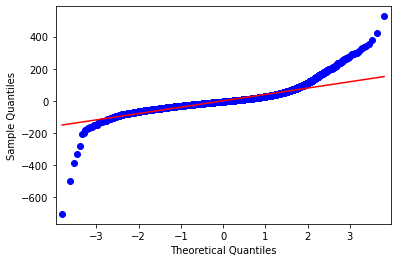

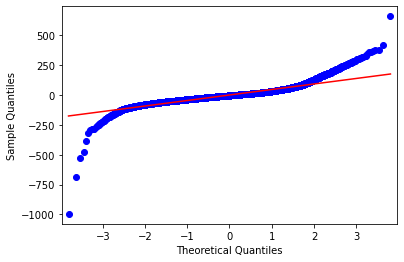

In [43]:
# Checking for normality

# Calculate our residuals
zip_train_residuals = y_zip_train - zip_train_preds
zip_test_residuals = y_zip_test - zip_test_preds

# QQ Plot
sm.qqplot(zip_train_residuals, line = 'r');

sm.qqplot(train_residuals, line = 'r');

## Remove Bedrooms > 8

In [44]:
kc_encoded_zip_br = kc_encoded_zip[kc_encoded_zip['bedrooms'] <= 8.0]

In [45]:
kc_encoded_zip_br.shape

(21586, 92)

In [46]:
# define X, y
X_zip_br = kc_encoded_zip.drop(columns=['price_sqft', 'id'])
y_zip_br = kc_encoded_zip['price_sqft']

# Train / Test split
X_zip_br_train, X_zip_br_test, y_zip_br_train, y_zip_br_test = train_test_split(
    X_zip_br, y_zip_br, test_size=0.33, random_state=41)

# add constant term/y-intercept to train data
X_zip__br_preds = sm.add_constant(X_zip_br_train)

In [47]:
#3rd model without properties containing > 8 bedrooms
model = sm.OLS(endog=y_zip_train, exog=X_zip_preds).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqft   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     882.4
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:25:16   Log-Likelihood:                -75013.
No. Observations:               14469   AIC:                         1.502e+05
Df Residuals:                   14378   BIC:                         1.509e+05
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 574.5120     40.776     14.089      0.000     494.586     654.438
price                   0.0003   2.16e-06    129.624      0.000       0.000       0.000
bedrooms               -5.3590      0.507    -10.561      0.000      -6.354      -4.364
bathrooms              -4.0325      0.860     -4.690      0.000      -5.718      -2.347
sqft_living            -0.0944      0.001   -101.780      0.000      -0.096      -0.093
sqft_lot                0.0001      1e-05     11.164      0.000    9.22e-05       0.000
floors                 -2.0120      0.926     -2.174      0.030      -3.826      -0.198
yr_built               -0.1354      0.020     -6.609      0.000      -0.176      -0.095
condition_Fair        -18.6772      4.097     -4.559      0.000     -26.707     -10.647
condition_Good          1.1290      0.926      1.219      0.223      -0.686       2.944
condition_Poor          3.4058     10.066      0.338      0.735     -16.326      23.137
condition_Very Good    -0.8739      1.491     -0.586      0.558      -3.796       2.048
grade_11 Excellent      1.2777      3.175      0.402      0.687      -4.945       7.500
grade_12 Luxury       -49.0125      6.374     -7.689      0.000     -61.507     -36.518
grade_13 Mansion     -244.9710     18.687    -13.110      0.000    -281.599    -208.343
grade_3 Poor          168.8801     43.593      3.874      0.000      83.432     254.328
grade_4 Low            59.1956     10.925      5.418      0.000      37.781      80.610
grade_5 Fair          -25.2743      4.461     -5.666      0.000     -34.018     -16.531
grade_6 Low Average   -32.4211      2.819    -11.500      0.000     -37.947     -26.895
grade_7 Average       -31.3485      2.322    -13.501      0.000     -35.900     -26.797
grade_8 Good          -19.4205      2.089     -9.297      0.000     -23.515     -15.326
grade_9 Better         -2.8199      2.017     -1.398      0.162      -6.773       1.133
zipcode_98002         -13.0936      4.631     -2.827      0.005     -22.171      -4.016
zipcode_98003           1.8722      4.237      0.442      0.659      -6.433      10.177
zipcode_98004         106.3909      4.408     24.134      0.000      97.750     115.032
zipcode_98005          76.1861      5.038     15.122      0.000      66.311      86.062
zipcode_98006          69.4837      3.752     18.518      0.000      62.129      76.839
zipcode_98007          65.9510      5.430     12.146      0.000      55.308      76.594
zipcode_98008          66.6834      4.259     15.655      0.000      58.334      75.032
zipcode_98010          29.9799      6.105      4.910      0.000      18.012      41.947
zipcode_98011          45.8747      4.645      9.875      0.000      36.769      54.980
zipcode_98014          27.8882      5.610      4.971      0.000      16.892      38.884
zip

In [48]:
zip_br_train_df = pd.concat([X_zip_br_train, y_zip_br_train], axis=1)

In [49]:
zip_br_train_df.corr().price_sqft.sort_values(ascending=False)

price_sqft       1.000000
price            0.558102
zipcode_98004    0.240053
zipcode_98112    0.178036
zipcode_98103    0.163231
                   ...   
zipcode_98038   -0.141164
zipcode_98042   -0.148205
zipcode_98023   -0.163257
bedrooms        -0.204289
yr_built        -0.291858
Name: price_sqft, Length: 91, dtype: float64

In [50]:
lr = LinearRegression()
lr.fit(X_zip_br_train, y_zip_br_train)

zip_br_train_preds = lr.predict(X_zip_br_train)
zip_br_test_preds = lr.predict(X_zip_br_test)

# Check R2 for Train/Test data.
print(f"Train R2: {r2_score(y_zip_br_train, zip_br_train_preds):.4f}")
print(f"Test R2: {r2_score(y_zip_br_test, zip_br_test_preds):.4f}")

Train R2: 0.8467
Test R2: 0.8449


In [51]:
# Checking for normality

# Calculate our residuals
zip_train_residuals = y_zip_train - zip_train_preds
zip_test_residuals = y_zip_test - zip_test_preds

# QQ Plot
sm.qqplot(zip_br_train_residuals, line = 'r');

sm.qqplot(train_residuals, line = 'r');

NameError: name 'zip_br_train_residuals' is not defined

## Dropping Mansions - rows & column

In [ ]:
kc_encoded_zip_br.loc[kc_encoded_zip_br['grade_13 Mansion'] == 1]

In [ ]:
kc_no_mansions = kc_encoded_zip_br.loc[kc_encoded_zip_br['grade_13 Mansion'] != 1]
kc_no_mansions = kc_no_mansions.drop(columns='grade_13 Mansion')
kc_no_mansions.shape

In [ ]:
# define X, y
X_mansions = kc_no_mansions.drop(columns=['price_sqft', 'id'])
y_mansions = kc_no_mansions['price_sqft']

# Train / Test split
X_mansions_train, X_mansions_test, y_mansions_train, y_mansions_test = train_test_split(
    X_mansions, y_mansions, test_size=0.33, random_state=41)

# add constant term/y-intercept to train data
X_mansions_preds = sm.add_constant(X_mansions_train)

In [ ]:
#3rd model without properties containing > 8 bedrooms
model = sm.OLS(endog=y_mansions_train, exog=X_mansions_preds).fit()
model.summary()

## Trying out Standard Scaler

In [ ]:
# Instantiate StandardScaler object
ss = StandardScaler()

In [ ]:
#ss.fit(X_train)
X_train_scaled = ss.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df

In [ ]:
#### Add con
X_train_scaled = sm.add_constant(X_train_scaled)
model = sm.OLS(endog=y_train, exog=X_train_scaled ).fit()
model.summary()

In [ ]:
## Observations:
#     this is laughably worse on R2 - 0.119
#     LOTS of high pvalues.

In [ ]:
y.hist();

In [ ]:
y_scld=np.log(y)
y_scld.hist();

In [ ]:
# Model with log-scaled y. R-squared degraded~3 points

X = X_preds
y = np.log(y_train)
model2 = sm.OLS(endog=y, exog=X).fit()
model2.summary()

In [ ]:
kc_encoded['grade_5 Fair'].sum()

In [ ]:
kc_encoded['grade_4 Low'].sum()

# Maybe drop since pvalues are 

In [ ]:
kc_encoded['condition_Poor'].sum()

# Maybe drop since pvalues are very high and minimal number of properties.

In [ ]:
kc_encoded['grade_8 Good'].sum()

# Too big a population to drop.

In [ ]:
# Model with log-scaled y, and dropped high pvalue columns

X = train_df.drop(columns=['price_sqft', 'floors', 'condition_Poor', 'grade_13 Mansion', 'grade_8 Good', 'grade_4 Low', 'grade_3 Poor'])
y = np.log(train_df['price_sqft'])
model3 = sm.OLS(endog=y, exog=X).fit()
model3.summary()

## Visualizing

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(16,20))


for xcol, ax in zip(kc_encoded.columns[:], [x for v in axes for x in v]):
    kc_encoded.plot.scatter(x=xcol, y='price_sqft', ax=ax, alpha=0.5, color='b')


In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_encoded.hist(ax = ax);

# Full EDA

In [ ]:
kc_housing = pd.read_csv('../data/kc_house_data.csv')


In [ ]:
kc_housing.shape

In [ ]:
kc_housing.describe()

In [ ]:
columns_of_note = list(kc_housing.columns)[3:8]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,16))


for xcol, ax in zip(kc_housing.columns[3:8], [x for v in axes for x in v]):
    kc_housing.plot.scatter(x=xcol, y='price', ax=ax, alpha=0.5, color='b')


In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_housing.hist(ax = ax);

In [ ]:
kc_housing.info()

In [ ]:
# Looking for NANs
kc_housing.isna().sum()

#### Added price/sqft feature

In [ ]:
kc_housing['price_sqft'] = kc_housing['price']/kc_housing['sqft_living']

In [ ]:
kc_housing.head()

#### Addressing Waterfront

There are ~2400 NA cells, no easy way to determine if waterfront or not. Recommend we drop this whole column--even if all of the NA cells should be YES for waterfront, that's less than 10% of our dataset, likely not meaningful to our analysis.

Drop Waterfront.

In [ ]:
kc_housing['waterfront'].value_counts()

In [ ]:
sum(kc_housing['waterfront'].isna())

In [ ]:
kc_housing['waterfront'] = kc_housing['waterfront'].fillna('N/A')

In [ ]:
kc_housing.sort_values(by='waterfront', ascending=False)

#### Addressing View

Doesn't seem to be many rows with na. Maybe encode as NA or preferably drop?+

Drop rows with N/A

In [ ]:
sum(kc_housing['view'].isna())

In [ ]:
kc_housing['view'].value_counts()

In [ ]:
# code to replace empty with N/A - add inplace if we decide to take this approach.
kc_housing['view'] = kc_housing['view'].fillna('N/A')

#### Addressing yr_renovated

Absent from simple data, maybe we add on later

~ 78% have 0 values, so assume they were not rennovated. I think rennovations are a meaningful datapoint, so we should encode this somehow. We could think about how recent the rennovation was to see if there is a meaningful relationship--for example, a home rennovated in 2020 is likely to sell better than a home rennovated only in 1980. Maybe we do some research on this and decide on a breakpoint for rennovated before/after? We could do a simple linear regression between yr renovated and price...

In [ ]:
sum(kc_housing['yr_renovated'].isna())

In [ ]:
kc_housing['yr_renovated'].value_counts(sort=False).head(75)

In [ ]:
kc_housing['yr_renovated'] = kc_housing['yr_renovated'].fillna('N/A')

In [ ]:
#dropping N/A for now to make model function.
kc_housing = kc_housing[(kc_housing.yr_renovated != 'N/A')]

#### Duplicate Properties

In [ ]:
# Looking for duplicate properties

kc_housing['id'].duplicated().sum()

In [ ]:
# Identify instances of the same property appearing more than once in the data set based on lattitude, longitude
# How do we treat this? Might not matter since there is only ~4-5 months of data here. as long as listing date 
# is different, probably OK to treat these as unique listings.


kc_housing[kc_housing.duplicated(subset=['id'], keep=False)].sort_values('id')

#### Addressing grade

This we need to encode as an ordinal.

In [ ]:
kc_housing['grade'].value_counts()

In [ ]:
# Create new column for numerical grade. 
# Should either drop df['grade'] or omit it from clean df.
kc_housing['grade_num']= kc_housing['grade'].apply(lambda x: x[:1]).astype(int)

In [ ]:
kc_housing['grade_num']

In [ ]:
kc_housing.info()

#### Addressing sqft_basement

Recommend we drop rows with N/A since we don't have an easy way to encode.
We have 454 unknown values here. need to drop or encode somehow. Maybe has basement or no basement?


In [ ]:
kc_housing['sqft_basement'].value_counts()

In [ ]:
kc_housing = kc_housing[(kc_housing.sqft_basement != '?')]

In [ ]:
kc_housing['sqft_basement'].value_counts()

# Encoding Categoricals

In [ ]:
# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['bedrooms', 'floors', 'condition', 'grade', 'view','waterfront']
cat_df = kc_housing[categoricals]
cat_df.head()

In [ ]:
# OneHot encoding for categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
categorical_cats = ohe.fit_transform(cat_df)
categorical_cats.todense()
categorical_df = pd.DataFrame(categorical_cats.todense(), columns=ohe.get_feature_names(categoricals))
categorical_df.head()

In [ ]:
categorical_df.shape

In [ ]:
kc_housing.shape

In [ ]:
# Append categorical dummies to original dataframe, and drop origical categorical columns.
data = kc_housing.drop(columns=categoricals)
kc_encoded = pd.concat([data.reset_index(drop=True), categorical_df.reset_index(drop=True)], axis=1)

In [ ]:
kc_encoded.shape

In [ ]:
kc_encoded.info()

# Nonsense Model with all columns

In [ ]:
X = kc_encoded.drop(columns=['date', 'lat', 'long', 'id','price_sqft','yr_renovated','sqft_basement'])
y = kc_encoded['price_sqft']

In [ ]:
X.isna().sum()

In [ ]:

model = sm.OLS(endog=y, exog=X).fit()
model.summary()

In [52]:
simple_housing_zip.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,price_sqft
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,7 Average,1955,98178,188.050847
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,7 Average,1951,98125,209.338521
2,5631500400,180000.0,2,1.00,770,10000,1.0,Average,6 Low Average,1933,98028,233.766234
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,7 Average,1965,98136,308.163265
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,8 Good,1987,98074,303.571429


In [56]:
simple_housing_zip.groupby('zipcode').mean()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,price_sqft
zipcode,,,,,,,,,
98001,4.651274e+09,2.811949e+05,3.393352,2.011773,1903.783934,14967.002770,1.430748,1980.867036,151.347966
98002,4.850894e+09,2.342840e+05,3.326633,1.839196,1627.743719,7517.633166,1.334171,1967.773869,151.174091
98003,4.674182e+09,2.941113e+05,3.357143,2.047321,1928.882143,10603.096429,1.310714,1976.885714,157.113414
98004,4.394237e+09,1.356524e+06,3.854890,2.527603,2909.022082,13104.220820,1.432177,1971.470032,475.609615
98005,4.961872e+09,8.102897e+05,3.851190,2.424107,2656.803571,19928.785714,1.279762,1969.744048,314.966998
...,...,...,...,...,...,...,...,...,...
98177,3.934998e+09,6.764194e+05,3.396078,2.100000,2323.333333,11904.403922,1.276471,1960.843137,292.982095
98178,4.291467e+09,3.106128e+05,3.305344,1.731870,1729.351145,8309.122137,1.185115,1955.232824,189.172528
98188,4.481851e+09,2.890783e+05,3.433824,1.863971,1802.772059,10126.080882,1.227941,1965.507353,169.007306
